In [ ]:
#| echo: false
# Read Data
b_data = pd.read_csv("https://github.com/bnkessler/DataScienceMachineLearningProject/blob/main/Data/CTA_-_Ridership_-_Bus_Routes_-_Daily_Totals_by_Route_20231020.csv?raw=true")
t_data = pd.read_csv("https://github.com/bnkessler/DataScienceMachineLearningProject/blob/main/Data/CTA_-_Ridership_-__L__Station_Entries_-_Daily_Totals_20231020.csv?raw=true")
a_data = pd.read_csv("/Users/ben/Documents/GitHub/DataScienceMachineLearningProject/Data/Traffic_Crashes_-_Crashes.csv")

In [259]:
#| echo: false
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import Lasso, LogisticRegression

## Part 1: Brief Data Summary

#### Data Set 1: CTA - Ridership - 'L' Station Entries - Daily Totals
Source: https://data.cityofchicago.org/Transportation/CTA-Ridership-L-Station-Entries-Daily-Totals/5neh-572f \
This dataset shows systemwide daily boardings for rail services provided by the Chicago Transit Authority (CTA), dating back to 2001. Daytypes are as follows: W = Weekday, A = Saturday,    U = Sunday/Holiday and it has the “station_id” as a primary identifier for each row. Columns represent the station name, date, day type, and rides. This data is in a tidy and clean condition, however, some modifications may be required in order for the data to work well in a model with the other datasets. The ridership data is collected as entry into each train station, which is recorded by entry through the turnstile, this also means that train transfers are not recorded.


#### Data Set 2: CTA - Ridership - Bus Routes - Daily Totals by Route
Source: https://data.cityofchicago.org/Transportation/CTA-Ridership-Bus-Routes-Daily-Totals-by-Route/jyb9-n7fm \
This dataset shows systemwide daily boardings for bus services provided by the Chicago Transit Authority (CTA), dating back to 2001. Day types are as follows: W = Weekday, A = Saturday, U = Sunday/Holiday and it has the date as a primary identifier for each row and columns for day type, bus rides, and total riders. The organization providing this dataset is the same as for the first dataset. This data is in a tidy and clean condition, however, some modifications may be required for the data to work well in a model with the other datasets. The ridership data is collected as boardings on each bus, which are recorded by bus fareboxes and farecard readers.


#### Data Set 3: 2019 Regional Greenhouse Gas Emissions Inventory — Transportation
Source: https://datahub.cmap.illinois.gov/documents/e38184bec64c4dfeb0ee584d4d641e75/about \
An Excel workbook containing a comprehensive inventory of greenhouse gas emissions from the transportation sector for the seven-county region. The inventory is GPC-compliant and includes breakouts for each county, the City of Chicago, and suburban Cook County. Data is provided for 2019, 2015, and 2010. This data will be useful as a separate reference table to provide supportive reasoning for conclusions that are found with the first two datasets.


#### Data Set 4:
Source:
https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if/data_preview
This dataset is an extensive catalog of traffic accidents in the Chicago area. The information is provided by the city of Chicago and more specifically the Chicago Police Department. The data is updated daily, however, the dataset was created on October 19th, 2017. There are many data types including numeric speed limit, categorical weather conditions, the date value, and many more. This data can be useful in showing the relationship between ridership and traffic accidents and can be a helpful guide for future investment strategies.

After combining datasets 1, 2, and 4, we will be able to create a model that can predict the number of accidents in a month depending on public transit ridership. We will use transit type, transit amount, and month to predict the number of accidents that occur. We will then run a second set of models on dataset 4 with the goal of determining the causes of serious accidents so as to better prevent them in the future.

In [188]:
#| echo: false
#| warning: false
# Mark train/bus
t_data["transit"] = t_data["date"].map(lambda x: "train")
b_data["transit"] = b_data["date"].map(lambda x: "bus")

# Clean Accident Data
a_data_clean = a_data[["CRASH_RECORD_ID", "FIRST_CRASH_TYPE", "CRASH_DAY_OF_WEEK", "CRASH_MONTH", "CRASH_DATE"]]
a_data_clean.columns = ["id", "crash_type", "day_type", "month", "year"]
a_data_clean["year"] = a_data_clean["year"].map(lambda x: x[6:10])
# a_data_clean.head()

# Join Transit datasets
joined_transit_data = b_data[["date", "daytype", "rides", "transit"]].merge(
    t_data[["date", "daytype", "rides", "transit"]],
    on = ["date", "daytype", "rides", "transit"],
    how = "outer"
)
joined_transit_data["year"] = joined_transit_data["date"].map(lambda x: x[6:10])
joined_transit_data["month"] = joined_transit_data["date"].map(lambda x: x[0:2])
joined_transit_data["day"] = joined_transit_data["date"].map(lambda x: x[3:5])
joined_transit_data["year"] = joined_transit_data["year"].astype(int)
# joined_transit_data.head()

# Filtered transit data
joined_transit_data_filtered = joined_transit_data[joined_transit_data["year"] >= 2017]

# Group transit data
grouped_transit_data = joined_transit_data_filtered[["daytype", "rides", "transit"]].groupby(["daytype", "transit"]).describe().reset_index()
grouped_transit_data["daytype"] = grouped_transit_data["daytype"].replace({"A": "Saturday", "U": "Sunday/Holiday", "W": "Weekday"})

# grouped_transit_data

# Add year column to accidents
a_data_clean["year"] = a_data_clean["year"].astype(int)
a_data_clean["day_type"] = a_data_clean["day_type"].astype(str)
a_data_clean["day_type"] = a_data_clean["day_type"].replace({"1": "Sunday/Holiday", "2": "Weekday", "3": "Weekday", "4": "Weekday", "5": "Weekday", "6": "Weekday", "7": "Saturday"})
a_data_filtered = a_data_clean[a_data_clean["year"] >= 2017]

acc = a_data_filtered[["day_type", "id"]].groupby(["day_type"]).count().reset_index()

# acc

# Makes total rides per transit type
rides = grouped_transit_data["rides"]["count"]
rides = rides.astype(float)

# Acc data for 2nd model set
acc_2 = a_data[["CRASH_RECORD_ID", "TRAFFIC_CONTROL_DEVICE", "POSTED_SPEED_LIMIT", "WEATHER_CONDITION", "LIGHTING_CONDITION", "TRAFFICWAY_TYPE", "LANE_CNT", "ROAD_DEFECT", "ROADWAY_SURFACE_COND", "INTERSECTION_RELATED_I", "CRASH_TYPE"]].dropna()

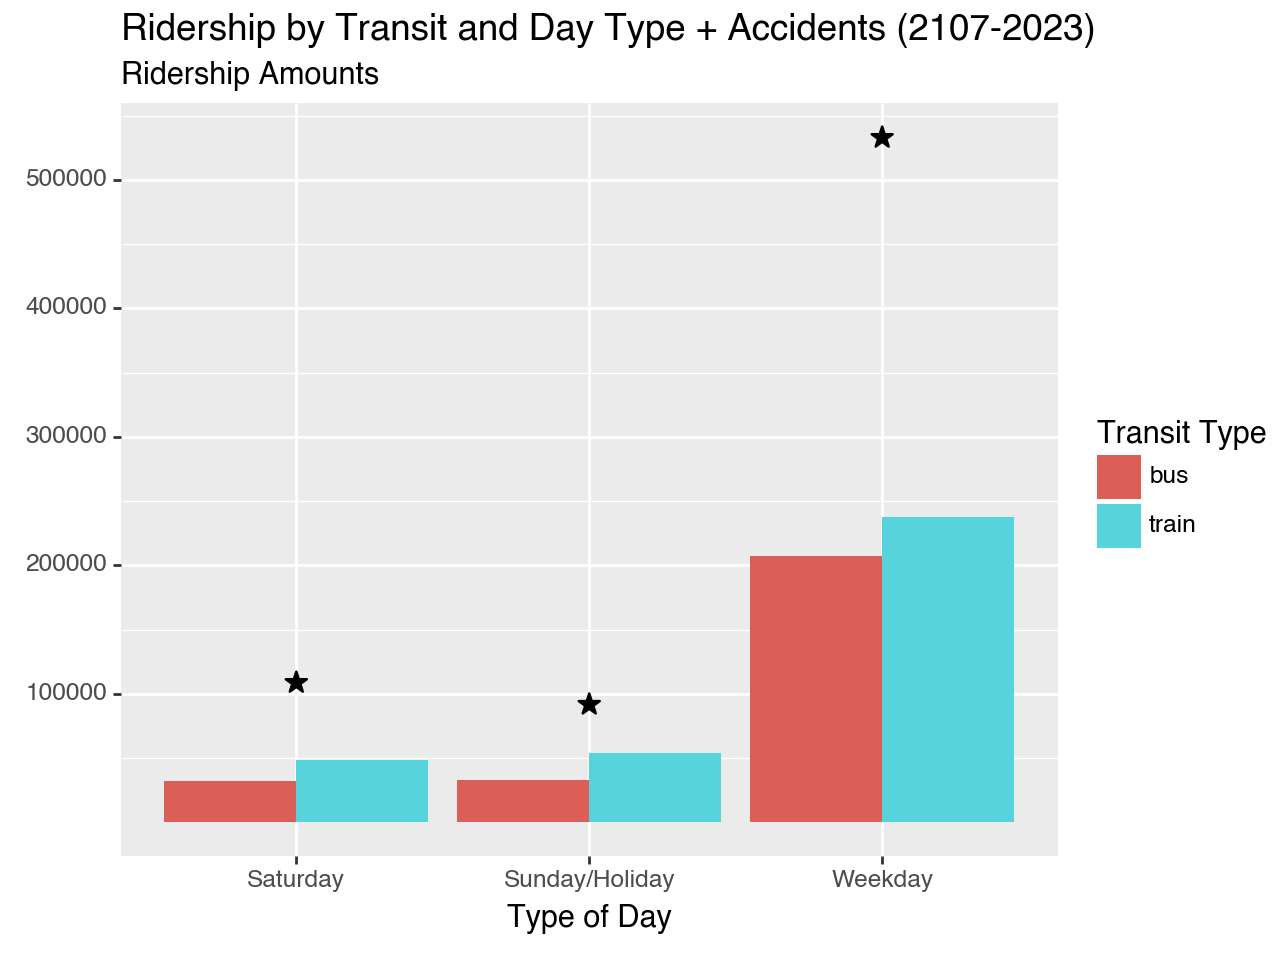

<Figure Size: (640 x 480)>

In [191]:
#| echo: false
from plotnine import ggplot, aes, geom_bar, geom_point, scale_y_continuous, labs
(ggplot(grouped_transit_data, aes(x = "daytype", y = rides, fill = "transit")) +
    geom_bar(stat = "identity", position = "dodge") +
    geom_point(acc, aes(x = "day_type", y = "id"), color = "Black", size = 4, shape = "*", inherit_aes = False) +
    scale_y_continuous(breaks = list(range(100000, 700000, 100000))) +
    labs(
        x = "Type of Day",
        y = "",
        title = "Ridership by Transit and Day Type + Accidents (2107-2023)",
        subtitle = "Ridership Amounts",
        fill = "Transit Type"
    )
)

As can be seen in the plot above, public transit ridership and accidents increase greatly during weekdays. It appears that more people taking public transit would result in more traffic accidents, but it is more likely that more people commuting causes this increase in accidents. For this reason, we believe that increasing public transit would actually decrease the number of accidents. We will now run models to see if this prediction is accurate. We plan to run a few  initial models that only examine the effect of day type, month, year, and type of public transit on traffic accidents. We also plan on running models to examine if traffic control devices, number of lanes, speed limit, weather, lighting, street type, road defects, and type of intersection are more likely to have serious accidents occur. If this is the case, then we could use the results of both models to argue for more public transit as a way to reduce serious traffic accidents and reduce the places that they occur most often.

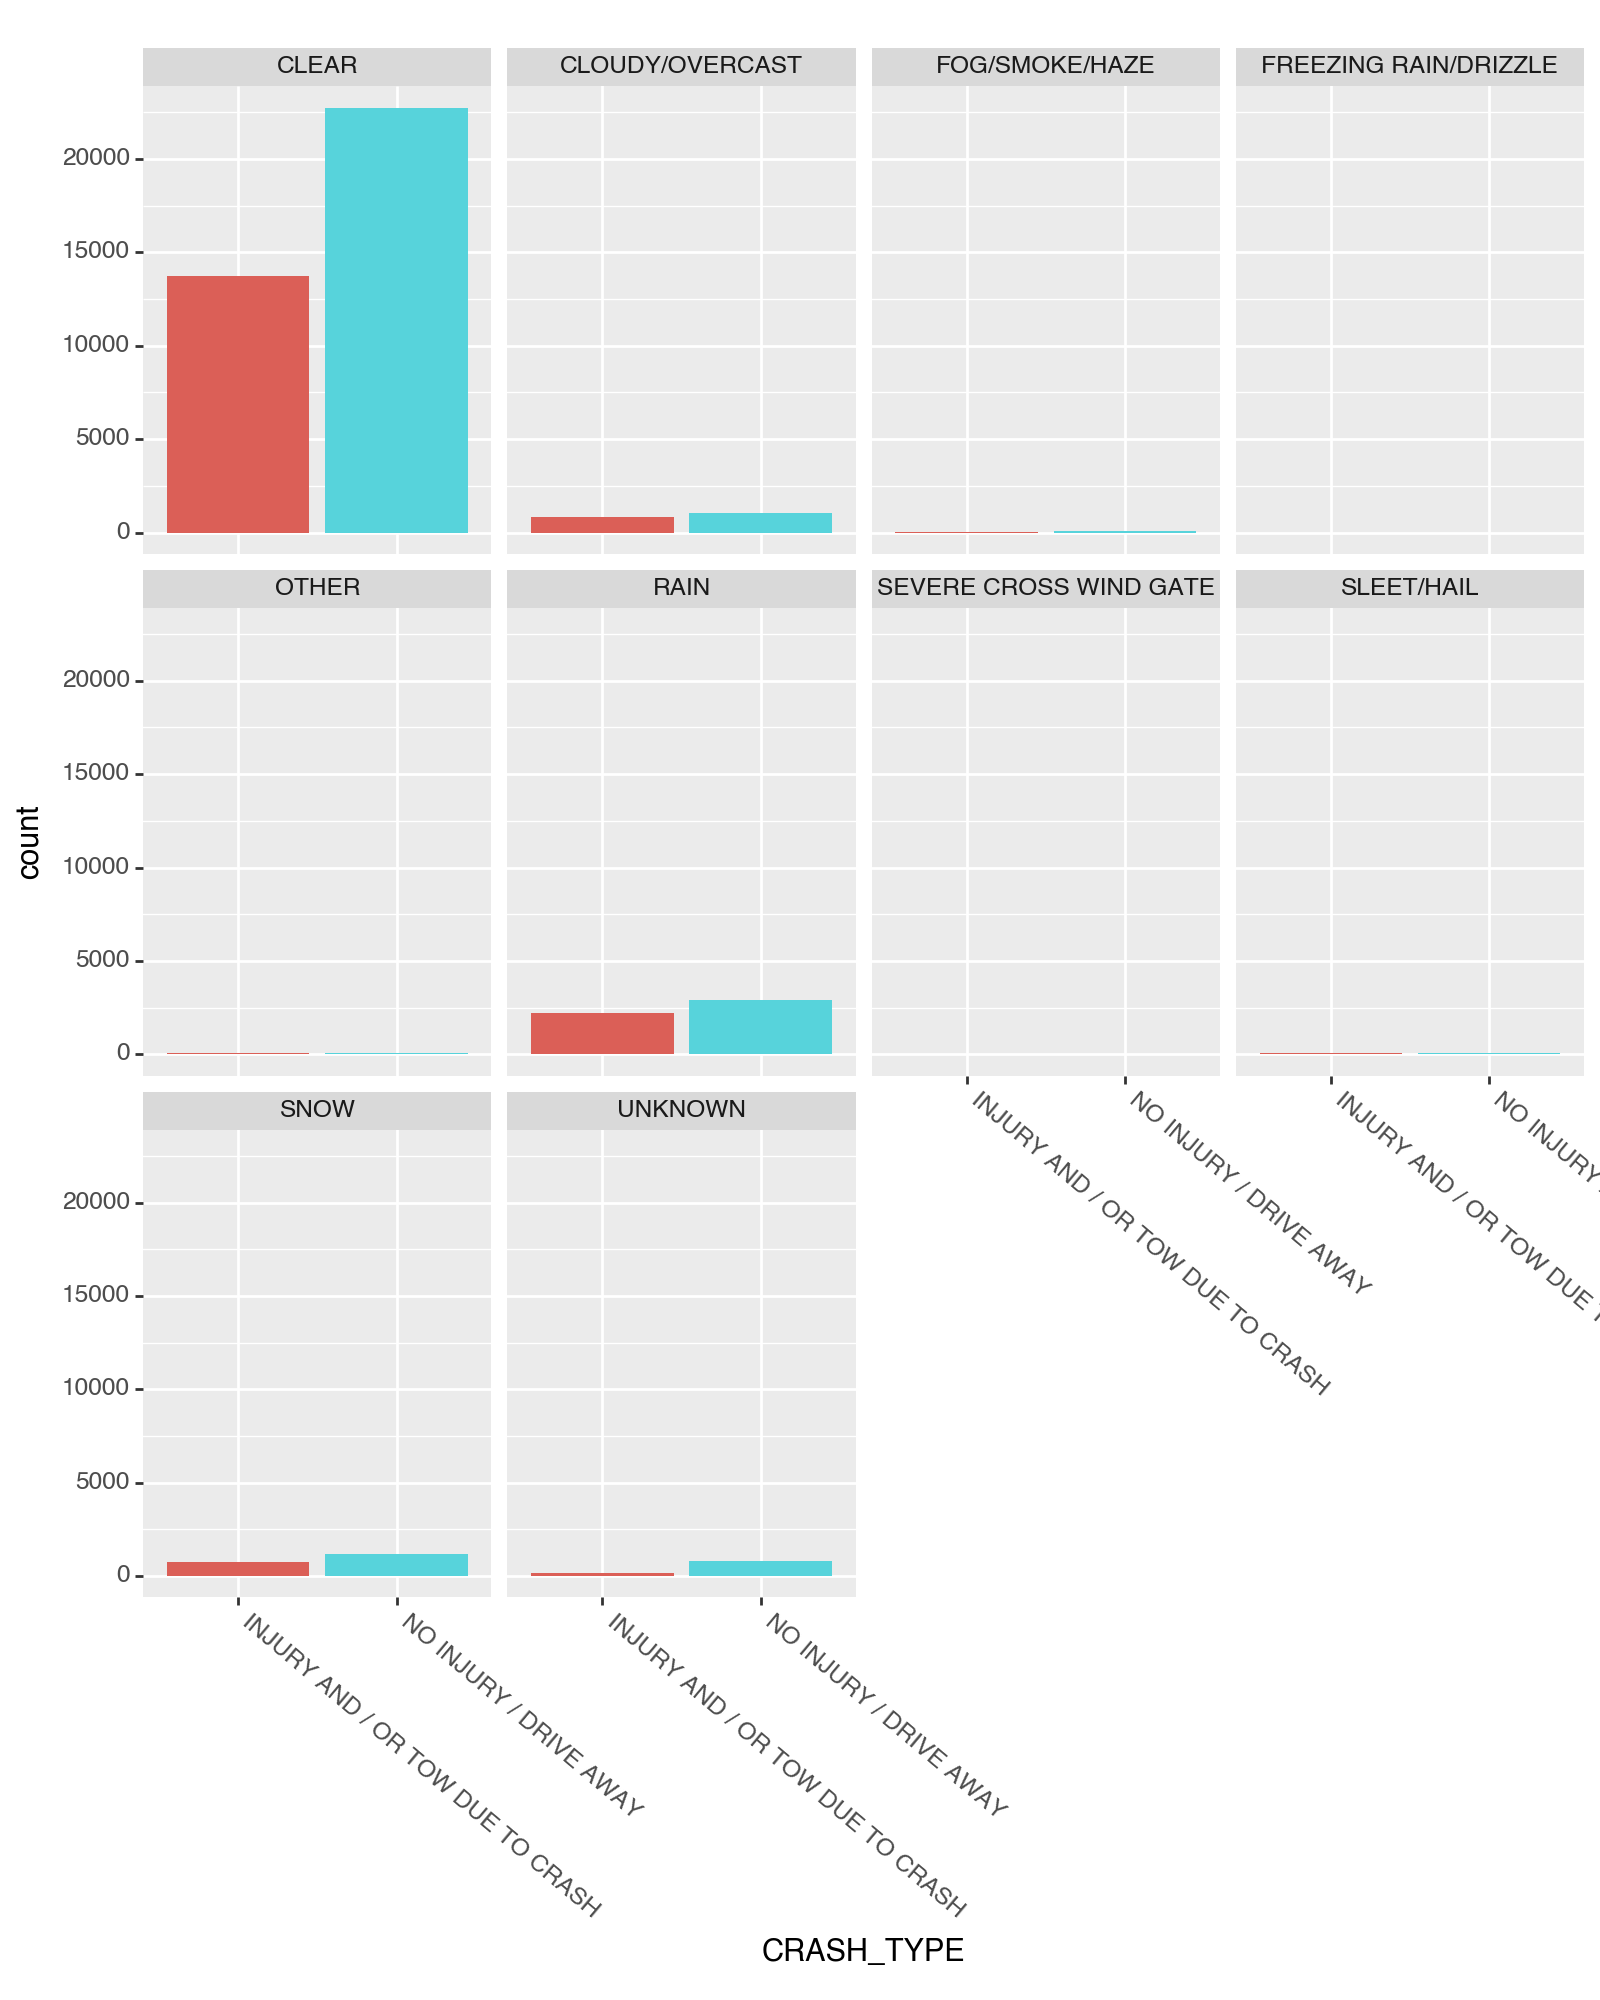

<Figure Size: (800 x 1000)>

In [ ]:
from plotnine import facet_wrap, theme, element_text
(ggplot(acc_2, aes(x = "CRASH_TYPE", fill = "CRASH_TYPE")) + 
    geom_bar(position = "dodge", show_legend = False) +
    facet_wrap("~ WEATHER_CONDITION") +
    theme(axis_text_x=element_text(angle=-40, ha="left"), figure_size = (8, 10)))

## Part 2: Research Questions and Models

We expect to use a regression model to predict the amount of accidents on the roads based on public transit ridership in both the bus and rail datasets. With the outcome of the model. 
Finally, using the traffic collision data we’ll be able to identify when the accidents are occurring to identify cases where car traffic could be improved. Additionally, we’ll combine this with the public transit data to see if the model results show that there is any correlation between public transportation and total car accidents, which we expect there to be.
Once we have the models for the bus and rail sets, as well as combined, we can use the emissions data to answer with more clarity what we think the best bus or station routes are to either bolster up or amplify further concerning the amount of carbon footprint reduction would be expected from potential actions.

To answer what affects the amount of riders using either a bus or station public transportation, we’ll have two different feature sets. For the bus, we will have the route number; full date, which can be split into day, month, and year variables separately; and the type of day, whether that’s a weekday, Saturday, or holiday. For the station, we will similarly have the date and type of day, but also the name of the station. We will be leaving out station_id as that’s just a key and won’t help in actual ridership prediction.
For discussing emissions, we’ll be using the same model specifications and feature sets as the previous question but expand upon it by weighting the ridership prediction in terms of overall emission to assist in formulating actionable decisions based on being more environmentally friendly.
For the traffic collision modeling, we’ll be using 9 features from the full collisions data that appear to us to be the most likely to be able to predict crashes. These will be: "TRAFFIC_CONTROL_DEVICE", "POSTED_SPEED_LIMIT", "WEATHER_CONDITION", "LIGHTING_CONDITION", "TRAFFICWAY_TYPE", "LANE_CNT", "ROAD_DEFECT", "ROADWAY_SURFACE_COND", "INTERSECTION_RELATED_I", “CRASH_DATE”. Most of these are self explanatory, except INTERSECTION_RELATED_I which is a binary variable simply indicating if the crash was from an intersection. Features that were not included tended to be more sparse or simply provided more detail on the crash itself, rather than potential causes of it. With this data we’ll then additionally combine the previous public transit data in several ways, such as by month or by year, to see if knowledge of public transit information helps predict the total crash count. 


#### Model Set 1

In [365]:
#| echo: false
#| warning: false
t_data_m1 = joined_transit_data.groupby(["month", "transit"]).count().reset_index()
a_data_m1 = a_data_filtered.groupby(["month"]).count().reset_index()
result_dict = dict(zip(["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"], a_data_m1["id"]))
m1_data = t_data_m1[["month", "transit", "rides"]]
m1_data["accidents"] = m1_data["month"].map(result_dict)
m1_data

X = m1_data[["rides", "month"]]

y = m1_data["accidents"]

X = X.astype(int)
y = y.astype(int)

ct = ColumnTransformer(
    [
        ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number)),
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop="first"), make_column_selector(dtype_include=object))
    ]
)

my_pipeline = Pipeline(
    [
        ("Preprocessing", ct),
        ("Lasso Regression", Lasso())
    ]
)

degrees = {"Lasso Regression__alpha": [1e-10, 1e-6, .0001, .001, .01, .1, 1]}

gscv = GridSearchCV(my_pipeline, degrees, cv = 5, scoring='r2')
gscv_fitted = gscv.fit(X, y)
test_scores = gscv_fitted.cv_results_["mean_test_score"]
gscv_fitted.best_estimator_

print(gscv_fitted.best_score_)

-64.1412340825926


/var/folders/s1/3gpr8bhn35jfwpp_kp1ny2w80000gn/T/ipykernel_51120/407603144.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


As can be seen above by the poor $R^2$ value above, our initial model is lacking heavily. This is expected as it is the first and most simple we intend to run and are planning on increasing the predictor variables as well as the model specification. We also will run many more cross validations with different model types to find a more accurate model. For our final report, we also plan to run another set of models that examine the causes of significant accidents to determine what the best course of action for SMART to follow.

## Part 3: Model Usage

The models will provide insights into historical ridership trends and the factors driving demand for bus versus rail transportation in Chicago. Key interpretations we may draw:

* Which mode of transport has seen more growth/decline historically - this will inform investment priorities
* Which routes/lines are most popular - resources can be allocated accordingly
* How ridership fluctuates by day of week, month, year - helps anticipate and plan for changes in demand
* Detect a connection between traffic accidents and the use of public transit

Additionally, our models will be able to forecast expected ridership for buses and trains given inputs like date, route, etc. SMART can leverage these predictions to:
* Anticipate surges/drops in demand and adjust schedules and frequency accordingly
* Optimize routes and connections based on projected usage
* Test scenarios of adding/removing services and estimate the ridership impacts
* Predict the environmental impact and use it to motivate investment and growth
* Use data to guide public policy changes and investment in infrastructure and road network as well as public transit.
* These models can give valuable insight into future actions and guide future decisions made for the Chicago transport systems. 


#### Ethical Implications

Developing predictive models for Chicago's public transportation requires a delicate balance between efficiency and ethical responsibility. Privacy is a primary concern; aggregating and analyzing individual travel behaviors must prioritize data anonymization. SMART should transparently communicate how ridership data contributes to transportation improvements, ensuring citizens are aware of their data's use. Addressing potential biases is crucial to prevent inadvertent disadvantages to certain demographic groups. Continuous evaluation is essential for equitable distribution of benefits across communities. Sample collection must reflect Chicago’s demographic distribution, while community engagement involving diverse stakeholders helps identify and rectify ethical concerns. 
Regular model audits and assessments, as part of SMART's ethical commitment, extend to the evaluation of safety predictions. This involves scrutinizing the effectiveness of safety interventions suggested by the models and identifying areas for improvement. Actively seeking feedback from road safety advocacy groups and engaging with the broader community allows for a comprehensive understanding of safety concerns, leading to more informed adjustments to predictive models and safety strategies.
In summary, SMART's ethical approach to predictive modeling not only optimizes transportation services but also actively contributes to reducing car crashes through data-driven insights, community engagement, and a commitment to ongoing safety evaluations. By aligning technological advancements with safety goals, SMART sets a model for responsible urban development that prioritizes the well-being of all citizens on Chicago's roads.
